In [255]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import sympy as smp
from scipy.stats import rv_continuous
plt.style.use(['science', 'notebook'])
from functions import *
import functions as f
import matplotlib
import scipy.ndimage as ndimage
from skimage.transform import rotate

Open all data

In [256]:
'''Attenuation coefficient data'''
df = pd.read_csv('water_data.txt', sep=' ', dtype=np.float32)
energy_d = df['Energy(MeV)'].values
coherent_d = df['Coherent(cm^2g^-1)'].values
compton_d = df['Compton(cm^2g^-1)'].values
photo_d = df['Photoelectric(cm^2g^-1)'].values
pairtrip_d = df['Pair+Triplet(cm^2g^-1)'].values
Etrans_d = df['Energy-Transfer(cm^2g^-1)'].values
Eabs_d = df['Energy-Absorption(cm^2g^-1)'].values
brem_d = df['1-g'].values
mu_d = coherent_d + compton_d+photo_d + pairtrip_d
mutr_d = df['Energy-Transfer(cm^2g^-1)'].values

In [258]:
binsx = np.arange(-15-voxel/2,15+(3/2)*voxel,voxel)
binsy = np.arange(-15-voxel/2,15+(3/2)*voxel,voxel)
binsz = np.arange(0,50+voxel,voxel)

# Problem 1

## Part A

Create radiation simulation object for photons emitted isotropically from point source.

In [259]:
N = 1000000
E0 = 50
E = E0*np.ones(N)
X = np.zeros((3,N))
Phi0 = 2*np.pi*uniform(size=N)
Theta0 = np.arccos(1-2*uniform(size=N))
Ang = np.array([Phi0, Theta0])
Ebins = 10.0**(np.linspace(-3,np.log10(E0), 100))
int_types = np.arange(4)
r = RadSim(E, X, Ang, Ebins, int_types, binsx, binsy, binsz)

Run simultion

In [260]:
while True:
    if r.iterate():
        break

Open up relative probability of different interactions at different energies

* From simulation
* Theoretically from attenuation coefficients

In [261]:
'''From simulation'''
int_total_per_energy = r.IntHist_p.sum(axis=0)
a1, a2, a3, a4 = r.IntHist_p / int_total_per_energy 

<ipython-input-261-533d3f393b70>:3: RuntimeWarning: invalid value encountered in true_divide
  a1, a2, a3, a4 = r.IntHist_p / int_total_per_energy


Plot

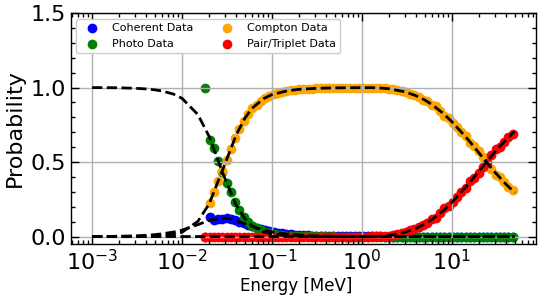

In [262]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(energy_d, coherent_d/mu_d, color='k', ls='--')
ax.plot(energy_d, photo_d/mu_d, color='k', ls='--')
ax.plot(energy_d, compton_d/mu_d, color='k', ls='--')
ax.plot(energy_d, pairtrip_d/mu_d, color='k', ls='--')
ax.semilogx()
ax.set_ylim(top=1.5)
ax.set_ylabel('Probability')
fig.suptitle('Energy [MeV]', y=0)
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a1, color='b', label=r'Coherent Data')
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a2, color='g', label=r'Photo Data')
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a3, color='orange', label=r'Compton Data')
plt.scatter(Ebins[0:-1] + np.diff(Ebins)/2, a4, color='red', label=r'Pair/Triplet Data')
ax.legend(fontsize=8, ncol=2, facecolor='white', framealpha=1, frameon=True, loc='upper left')
plt.grid()
plt.savefig('images/q1.png', dpi=200)
plt.show()

## Part B

Get analytical formula for average kinetic energy given to electrons as a function of incoming photon energy.

In [263]:
E, alpha, T, theta = smp.symbols(r'E \alpha T \theta', real=True, positive=True)
T_expr = E*alpha*(1-smp.cos(theta))/(1+alpha*(1-smp.cos(theta)))
theta_expr = smp.solve(T-T_expr, theta)[1]
dsdo_expr = smp.Rational(1,2)*(1+smp.cos(theta)**2)/(1+alpha*(1-smp.cos(theta)))**2 * \
            ( 1 + alpha**2 * (1-smp.cos(theta))**2 / ((1+smp.cos(theta)**2)*(1+alpha*(1-smp.cos(theta)))))
dsdT = 2*smp.pi*smp.sin(theta) * dsdo_expr / smp.diff(T_expr, theta)
dsdT = dsdT.subs(theta, theta_expr).simplify()
Tmin = 0 
Tmax = 2*E*alpha/(1+2*alpha)
sigma_check = smp.integrate(dsdT, (T, Tmin, Tmax)).expand().simplify().simplify()
pdf = dsdT / sigma_check
avgT = smp.integrate(pdf*(T/E), (T, Tmin, Tmax)).simplify().simplify()
avgT_f = smp.lambdify(alpha, avgT)

Print this value (this is also Equation 6 in the report)

In [264]:
avgT

(-20*\alpha**5 + 102*\alpha**4 + 186*\alpha**3 + 102*\alpha**2 + 18*\alpha + (24*\alpha**5 - 12*\alpha**4 - 126*\alpha**3 - 141*\alpha**2 - 60*\alpha - 9)*log(2*\alpha + 1))/(3*(4*\alpha**5 + 38*\alpha**4 + 50*\alpha**3 + 24*\alpha**2 + 4*\alpha + (8*\alpha**5 - 4*\alpha**4 - 34*\alpha**3 - 35*\alpha**2 - 14*\alpha - 2)*log(2*\alpha + 1)))

Get **theoretical arrays**

In [265]:
energy_arr = np.linspace(0.01, 50, 10000) 
avgT_arr = avgT_f(energy_arr/0.511)

Get **compton angles from simulation**

In [266]:
ratios, bins = np.histogram(r.comptonenergies, Ebins, weights=r.comptonratios)
total, bins = np.histogram(r.comptonenergies, Ebins)
T = ratios/total
Ep = bins[:-1] + np.diff(bins)/2

<ipython-input-266-1903f69e0dfa>:3: RuntimeWarning: invalid value encountered in true_divide
  T = ratios/total


Plot

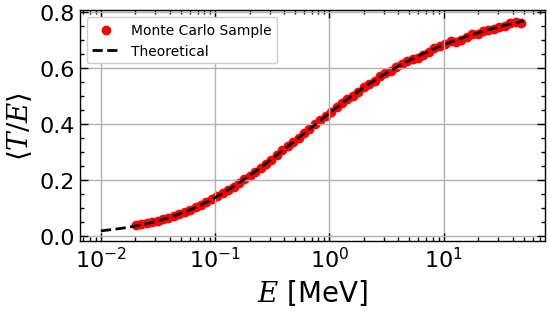

In [267]:
plt.figure(figsize=(6,3))
plt.scatter(Ep, T, color='r', label='Monte Carlo Sample')
plt.plot(energy_arr, avgT_arr, color='k', ls='--', label='Theoretical')
plt.xlabel('$E$ [MeV]', fontsize=20)
plt.ylabel(r'$\left<T/E\right>$', fontsize=20)
plt.grid()
plt.legend(fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper left')
plt.semilogx()
plt.savefig('images/q2.png', dpi=200)
plt.show()

## Part C

Forloop to calculate average number of interactions at different energies:

In [270]:
avg_inters = []
for E0 in energy_d:
    N = 5000
    tot_inters = 0
    E = E0*np.ones(N)
    X = np.zeros((3,N))
    Phi0 = 2*np.pi*uniform(size=N)
    Theta0 = np.arccos(1-2*uniform(size=N))
    Ang = np.array([Phi0, Theta0])
    Ebins = 10.0**(np.linspace(-3,np.log10(E0), 100))
    int_types = np.arange(4)
    ri = RadSim(E, X, Ang, Ebins, int_types, binsx, binsy, binsz)
    while True:
        tot_inters+=np.sum(ri.Act_p)
        if ri.iterate():
            break
    avg_inters.append(tot_inters/N)
avg_inters = np.array(avg_inters)

Plot this:

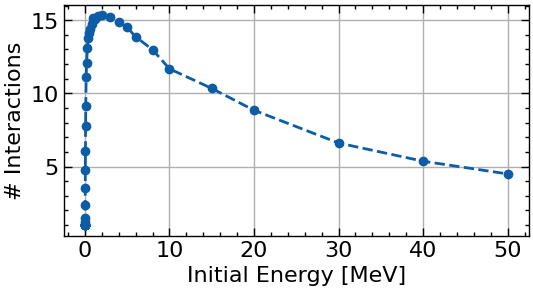

In [273]:
plt.figure(figsize=(6,3))
plt.plot(energy_d, avg_inters, 'o--')
plt.xlabel('Initial Energy [MeV]')
plt.ylabel('# Interactions')
plt.grid()
plt.savefig('images/q3.png', dpi=200)
plt.show()

## Part D

Get $d\sigma/d\theta$ as a numerical function

In [150]:
dsdt = 2*smp.pi*dsdo_expr*smp.sin(theta)
dsdt = dsdt.simplify()
dsdt_f = smp.lambdify([alpha, theta], dsdt)

Get number of particles at different energies

In [151]:
theta_num = np.linspace(0, np.pi, 100)
N_CE, E_CE = np.histogram(r.comptonenergies, bins=1000)
E_CE = E_CE[1:] - np.diff(E_CE)[0]/2

To get pdf over a spectrum of energies:

$$f(\theta) = \frac{\int_E f(\theta, E) dN(E)}{\int_E dN(E)}$$

In [164]:
def compute_rest_theory():
    b = dsdt_f(*np.meshgrid(E_CE/0.511, theta_num))
    b = b/np.sum(b, axis=0)
    rest_theory = np.sum(b *N_CE, axis=1)
    rest_theory = rest_theory / sum(rest_theory * np.diff(theta_num)[0])
    return rest_theory

In [165]:
rest_theory = compute_rest_theory()

Note: there should be no preferred solid angle in the phantom rest frame since decays occur isotropically

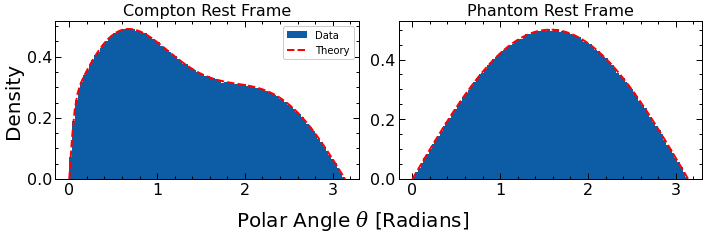

In [169]:
fig, ax = plt.subplots(figsize=(10,3))
plt.subplot(121)
plt.hist(r.comptonthetas, bins=100, density=True, label='Data')
plt.plot(theta_num, rest_theory, color='r', ls='--', lw=2, label='Theory')
plt.title('Compton Rest Frame')
plt.ylabel('Density', fontsize=20)
plt.legend(fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.subplot(122)
plt.hist(r.comptonthetas_rest, bins=100, density=True, label='Monte Carlo')
plt.plot(theta_num, 0.5*np.sin(theta_num), color='r', ls='--', lw=2)
plt.title('Phantom Rest Frame')
fig.tight_layout()
fig.suptitle(r'Polar Angle $\theta$ [Radians]',x=0.5,y=0, ha='center', fontsize=20)
plt.savefig('images/q4.png', dpi=200)
plt.show()

# Problem 2

Open data

In [241]:
path = "F:\\Data\\Phys539\\"

In [242]:
tot_hist = np.load(path+'tot_hist.npy')
kerma_hist = np.load(path+'kerma_hist.npy')
dose_hist = np.load(path+'dose_hist.npy')
prim_hist = np.load(path+'prim_hist.npy')
voxel = 0.1
binsx = np.arange(-15-voxel/2,15+(3/2)*voxel,voxel)
binsy = np.arange(-15-voxel/2,15+(3/2)*voxel,voxel)
binsz = np.arange(0,50+voxel,voxel)
mid_xy = tot_hist.shape[0]//2

## Kerma vs. Dose Plots

Get meshgrid of voxel locations (axial planes)

In [243]:
x = binsx[1:] - np.diff(binsx)[0]/2
y = binsy[1:] - np.diff(binsy)[0]/2
xv, yv = np.meshgrid(x,y)

Get arrays of Kerma at $R<1$, $R>1$, and across entire slice

In [245]:
z = binsz[1:] -np.diff(binsz)/2
MV_to_J = 1.60218e-13
J_to_GY =  1 / (1 * voxel**3 / 1000) #1/(rho * volume)
f = MV_to_J * J_to_GY
N=1e9

oc = xv**2 + yv**2 <= 1**2
oc_bool = np.tile(oc, (kerma_hist.shape[-1],1,1)).astype(int)
CF = len(oc_bool[0].ravel()) / np.sum(oc_bool[0])
kerma_center = np.mean(kerma_hist*oc_bool.T, axis=(0,1))* CF *f /N
dose_center = np.mean(dose_hist*oc_bool.T, axis=(0,1))* CF* f /N

oc = xv**2 + yv**2 >= 1**2
oc_bool = np.tile(oc, (kerma_hist.shape[-1],1,1)).astype(int)
CF = len(oc_bool[0].ravel()) / np.sum(oc_bool[0])
kerma_outer = np.mean(kerma_hist*oc_bool.T, axis=(0,1))* CF *f /N
dose_outer = np.mean(dose_hist*oc_bool.T, axis=(0,1))* CF *f /N

kerma_tot = np.mean(kerma_hist, axis=(0,1))* f /N
dose_tot = np.mean(dose_hist, axis=(0,1))* f /N

Plot depth curves:

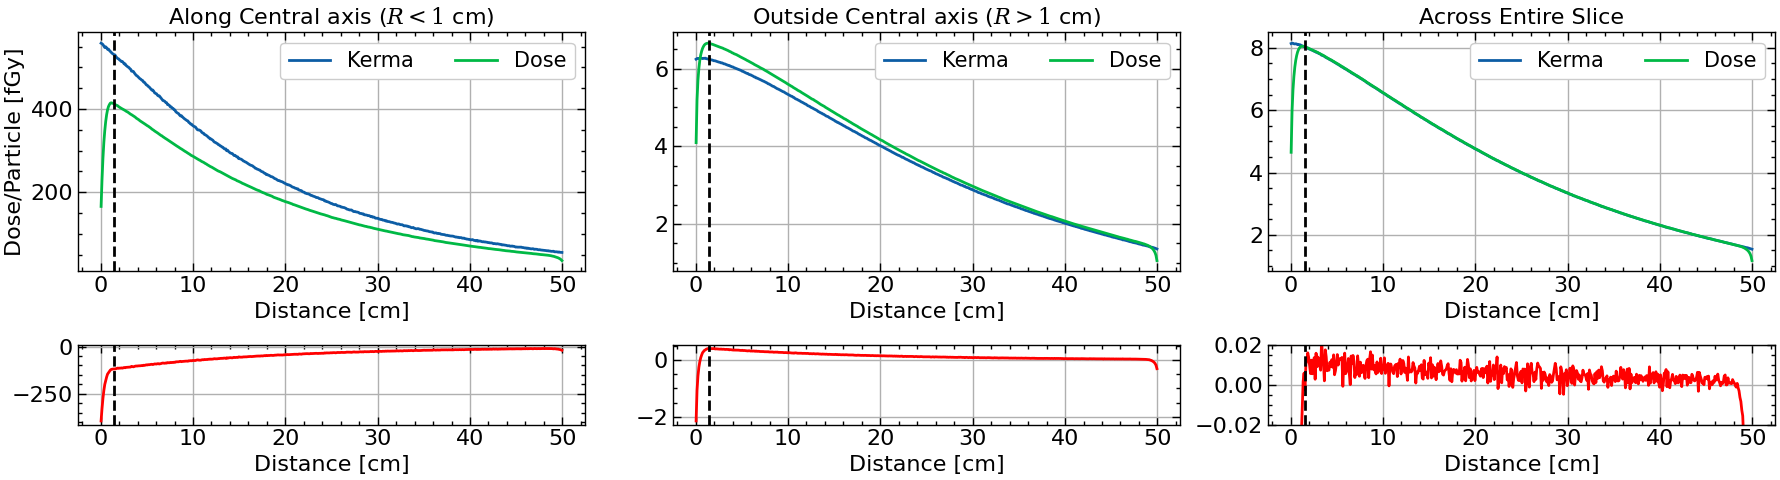

In [249]:
fig, ax = plt.subplots(2,3, figsize=(18,5), gridspec_kw={'height_ratios': [3, 1]})
plt.subplot(231)
plt.title('Along Central axis ($R<1$ cm)')
plt.plot(z, kerma_center*1e15, label='Kerma')
plt.plot(z, dose_center*1e15, label='Dose')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(ncol=2, fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.ylabel('Dose/Particle [fGy]')
plt.subplot(234)
plt.plot(z, dose_center*1e15-kerma_center*1e15, label='Kerma', color='r')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.xlabel('Distance [cm]')
plt.subplot(232)
plt.title('Outside Central axis ($R>1$ cm)')
plt.plot(z, kerma_outer*1e15, label='Kerma')
plt.plot(z, dose_outer*1e15, label='Dose')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(ncol=2, fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.subplot(235)
plt.plot(z, dose_outer*1e15-kerma_outer*1e15, label='Kerma', color='r')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.xlabel('Distance [cm]')
plt.subplot(233)
plt.title('Across Entire Slice')
plt.plot(z, kerma_tot*1e15, label='Kerma')
plt.plot(z, dose_tot*1e15, label='Dose')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.legend(ncol=2, fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.subplot(236)
plt.plot(z, dose_tot*1e15-kerma_tot*1e15, label='Kerma', color='r')
plt.ylim(bottom=-0.2e-1, top=0.2e-1)
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.xlabel('Distance [cm]')
fig.tight_layout()
plt.savefig('images/dosekerma.png', dpi=200)
plt.show()

## Percent Depth dose Plot

Plot percent depth dose curve:

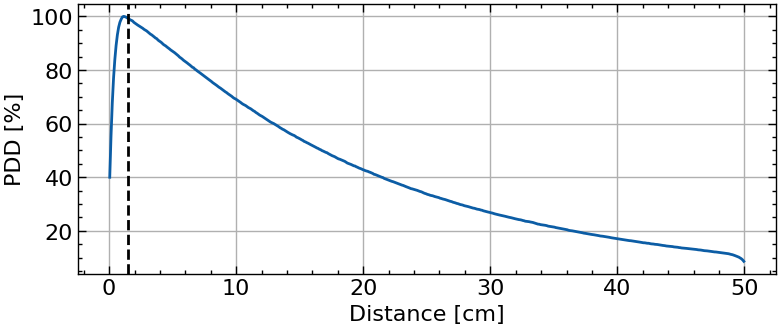

In [21]:
plt.figure(figsize=(9,3.5))
plt.subplot(111)
plt.plot(z, dose_center/max(dose_center) * 100, label='Dose')
plt.axvline(1.5, color='k', ls='--')
plt.grid()
plt.xlabel('Distance [cm]')
plt.ylabel('PDD [%]')
plt.savefig('images/p5.png', dpi=200)
plt.show()

## Axial Cross Section Plots

Get axial cross sections:

In [43]:
d = x
eps = 1e-5
def get_cross(axis, value, eps=1e-5):
    if axis=='x':
        arr = (dose_hist[:,mid_xy,np.abs(z-voxel/2-value)<eps] + dose_hist[:,mid_xy,np.abs(z+voxel/2-value)<eps])/2  * f / N 
    elif axis=='y':
        arr= (dose_hist[mid_xy,:,np.abs(z-voxel/2-value)<eps] + dose_hist[mid_xy,:,np.abs(z+voxel/2-value)<eps])/2  * f / N
    return arr.ravel()
cross_x_1 = get_cross('x', 1.5) 
cross_x_5 = get_cross('x', 5) 
cross_x_10 = get_cross('x', 10)  
cross_x_20 = get_cross('x', 20) 
cross_y_1 = get_cross('x', 1) 
cross_y_5 = get_cross('x', 5) 
cross_y_10 = get_cross('x', 10)  
cross_y_20 = get_cross('x', 20) 

Plot:

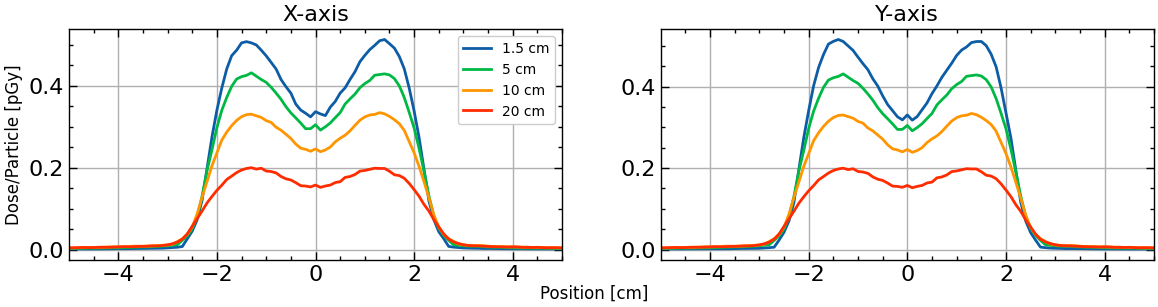

In [46]:
fig = plt.figure(figsize=(14,3))
plt.subplot(121)
plt.plot(d,cross_x_1.ravel()*1e12, label='1.5 cm')
plt.plot(d,cross_x_5.ravel()*1e12, label='5 cm')
plt.plot(d,cross_x_10.ravel()*1e12, label='10 cm')
plt.plot(d,cross_x_20.ravel()*1e12, label='20 cm')
plt.ylabel('Dose/Particle [pGy]', fontsize=12)
plt.xlim(-5,5)
plt.title('X-axis')
plt.grid()
plt.legend(fontsize=10, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.subplot(122)
plt.plot(d,cross_y_1.ravel()*1e12, label='1.5 cm')
plt.plot(d,cross_y_5.ravel()*1e12, label='5 cm')
plt.plot(d,cross_y_10.ravel()*1e12, label='10 cm')
plt.plot(d,cross_y_20.ravel()*1e12, label='20 cm')
plt.title('Y-axis')
plt.grid()
plt.xlim(-5,5)
fig.suptitle(r'Position [cm]',x=0.5,y=0.03, ha='center', fontsize=12)
plt.savefig('images/p6.png', dpi=200)
plt.show()

## Isodose Plot

Get data for coronal slice for isodose plot. Rotate phantom around its central axis to permit better statistics:

In [47]:
dose_smooth = np.zeros(dose_hist.shape)
for ang in np.linspace(0, 360, 40):
    dose_smooth+=rotate(dose_hist, ang)
dose_smooth = dose_smooth[mid_xy]

Get meshgrid for plotting:

In [48]:
rad = binsx[1:] - np.diff(binsx)[0]/2
z = binsz[1:] - np.diff(binsz)[0]/2
zv, rv = np.meshgrid(z, rad)

Plot:

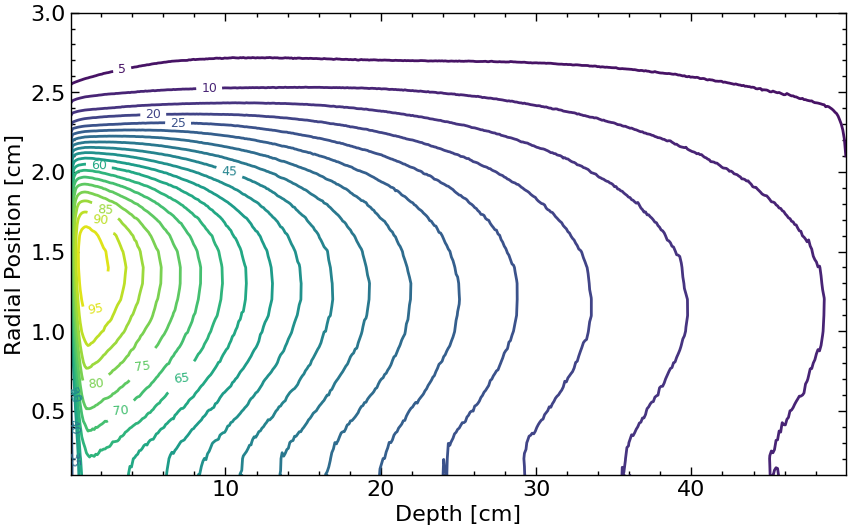

In [156]:
fig, ax = plt.subplots(figsize=(10,6))
CS = ax.contour(zv, rv, dose_smooth/dose_smooth.max() *100, levels=20)
ax.clabel(CS, CS.levels, inline=True, fontsize=9)
plt.xlabel('Depth [cm]')
plt.ylabel('Radial Position [cm]')
plt.ylim(0.1,3)
plt.savefig('images/isodose.png', dpi=200)
plt.show()

## Theoretical Kerma Plot

$$dE_{trans}(x,y,z) = N_{\gamma}(x,y,z) A(E) \cdot E \cdot dF(E,z)$$
$$ E_{trans}(x,y,z) = N_{\gamma}(x,y,z) \int_E A(E) \cdot E f(E,z) dE$$

* $N_{\gamma}$ counted from monte carlo
* $A(E) = \mu_{tr}/\mu$, which depends on energy
* $F(E,z)$ is cdf and $f(E,z)$ is pdf of photon energy at a distance $z$ in the phantom

where $f(E,z)=f(E)e^{-\mu(E)z} / \int f(E)e^{-\mu(E)z} dE$

In [208]:
# Compute integral factor
def compute_factor(z):
    d1 = np.array([0, 2480,15000,27290,37590,46310,53760,60140,65680,70460,
                       74630,78290, 81510, 84330, 86860, 89090, 91060, 92790,
                       94330, 95670, 96840, 97850, 98710, 99420, 100000]) /100000
    d2 = np.concatenate([np.array([0.2]), np.arange(0.25, 6.25, 0.25)])
    cdf_f = interp1d(d2,d1,kind='cubic')
    pdf_f = cdf_f._spline.derivative(nu=1)
    d1 = mutr_d/mu_d
    d2 = energy_d
    ratio_f = interp1d(d2,d1,kind='cubic')
    mu_f = interp1d(d2,mu_d,kind='cubic')
    ees = np.linspace(0.2,6,1000)
    return sum(ratio_f(ees)*ees*pdf_f(ees).ravel()*np.exp(-mu_f(ees)*z)) * np.diff(ees)[0] \
            / (sum(pdf_f(ees).ravel()*np.exp(-mu_f(ees)*z)) * np.diff(ees)[0])

Get predicted Kerma using the factor above:

In [230]:
factor = np.vectorize(compute_factor)(z)
kerma_pred_hist = prim_hist * factor

Get Kerma across entire axial slice:

In [238]:
oc = xv**2 + yv**2 <= 100**2
oc_bool = np.tile(oc, (kerma_hist.shape[-1],1,1)).astype(int)
CF = len(oc_bool[0].ravel()) / np.sum(oc_bool[0])
kerma_center = np.mean(kerma_hist*oc_bool.T, axis=(0,1))* CF *f /N
kerma_pred_center = np.mean(kerma_pred_hist*oc_bool.T, axis=(0,1))* CF *f /N 

Plot:

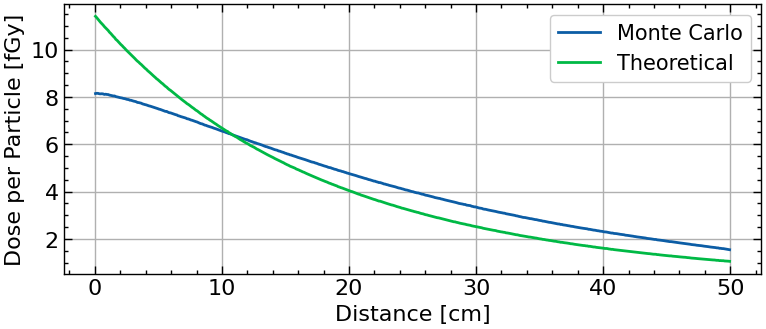

In [239]:
plt.figure(figsize=(9,3.5))
plt.plot(z, kerma_center*1e15, label='Monte Carlo')
plt.plot(z, kerma_pred_center*1e15, label='Theoretical')
plt.grid()
plt.legend(fontsize=15, facecolor='white', framealpha=1, frameon=True, loc='upper right')
plt.xlabel('Distance [cm]')
plt.ylabel('Dose per Particle [fGy]')
plt.savefig('kerma_v_kermapred.png', dpi=200)
plt.show()

## Incident Photon Probability plots

Define data given to us:

In [68]:
d1 = np.array([0, 2480,15000,27290,37590,46310,53760,60140,65680,70460,
                       74630,78290, 81510, 84330, 86860, 89090, 91060, 92790,
                       94330, 95670, 96840, 97850, 98710, 99420, 100000]) /100000
d2 = np.concatenate([np.array([0.2]), np.arange(0.25, 6.25, 0.25)])
A_f = interp1d(d2,d1,kind='cubic')
ees = np.linspace(0.25,6,1000)
E_distrid = np.diff(A_f(ees))/np.diff(ees)[0]
rrs = np.sqrt(2*np.log(6/ees))

Radius of maximum energy concentration:

In [69]:
Rmax = np.sqrt(2*np.log(6/ees[1:][np.argmax(ees[1:]*E_distrid)]))

Plot pdfs

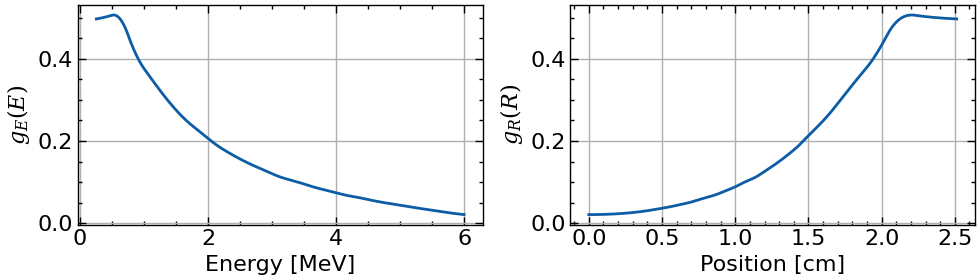

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
plt.subplot(121)
plt.plot(ees[1:], E_distrid)
plt.xlabel('Energy [MeV]')
plt.ylabel('$g_E(E)$')
plt.grid()
plt.subplot(122)
plt.plot(rrs[1:], E_distrid)
plt.xlabel('Position [cm]')
plt.ylabel('$g_R(R)$')
plt.grid()
fig.tight_layout()
plt.savefig('images/energy_beam_pdf.png', dpi=200)
plt.show()